In [4]:
import aptwrapper
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.dates
import pickle
import datetime as dt
from skimage.segmentation import mark_boundaries
import scipy.stats
import matplotlib.gridspec
import PIL

import utils

# SIM

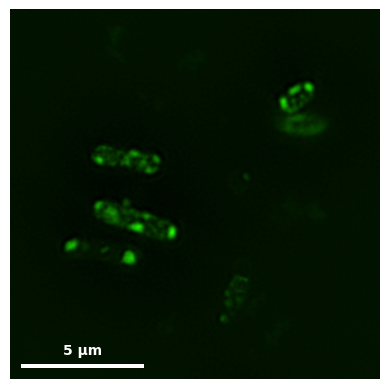

In [86]:
import PIL.Image

def plot_sim(ax=None):
    if ax is None: fig, ax = plt.subplots()
    aptwrapper.add_scalebar(ax=ax, length_fraction=.4)
    ax.imshow(PIL.Image.open('../primary_data/supp_sim_microscopy/heat_fov1_3dsim488_exp500_pow50_Reconstructed#5.png'), extent=(0, 15, 0, 15))
    ax.axis('off')

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/supp_pftaa.eps', bbox_inches='tight')

plot_sim()

# SEM

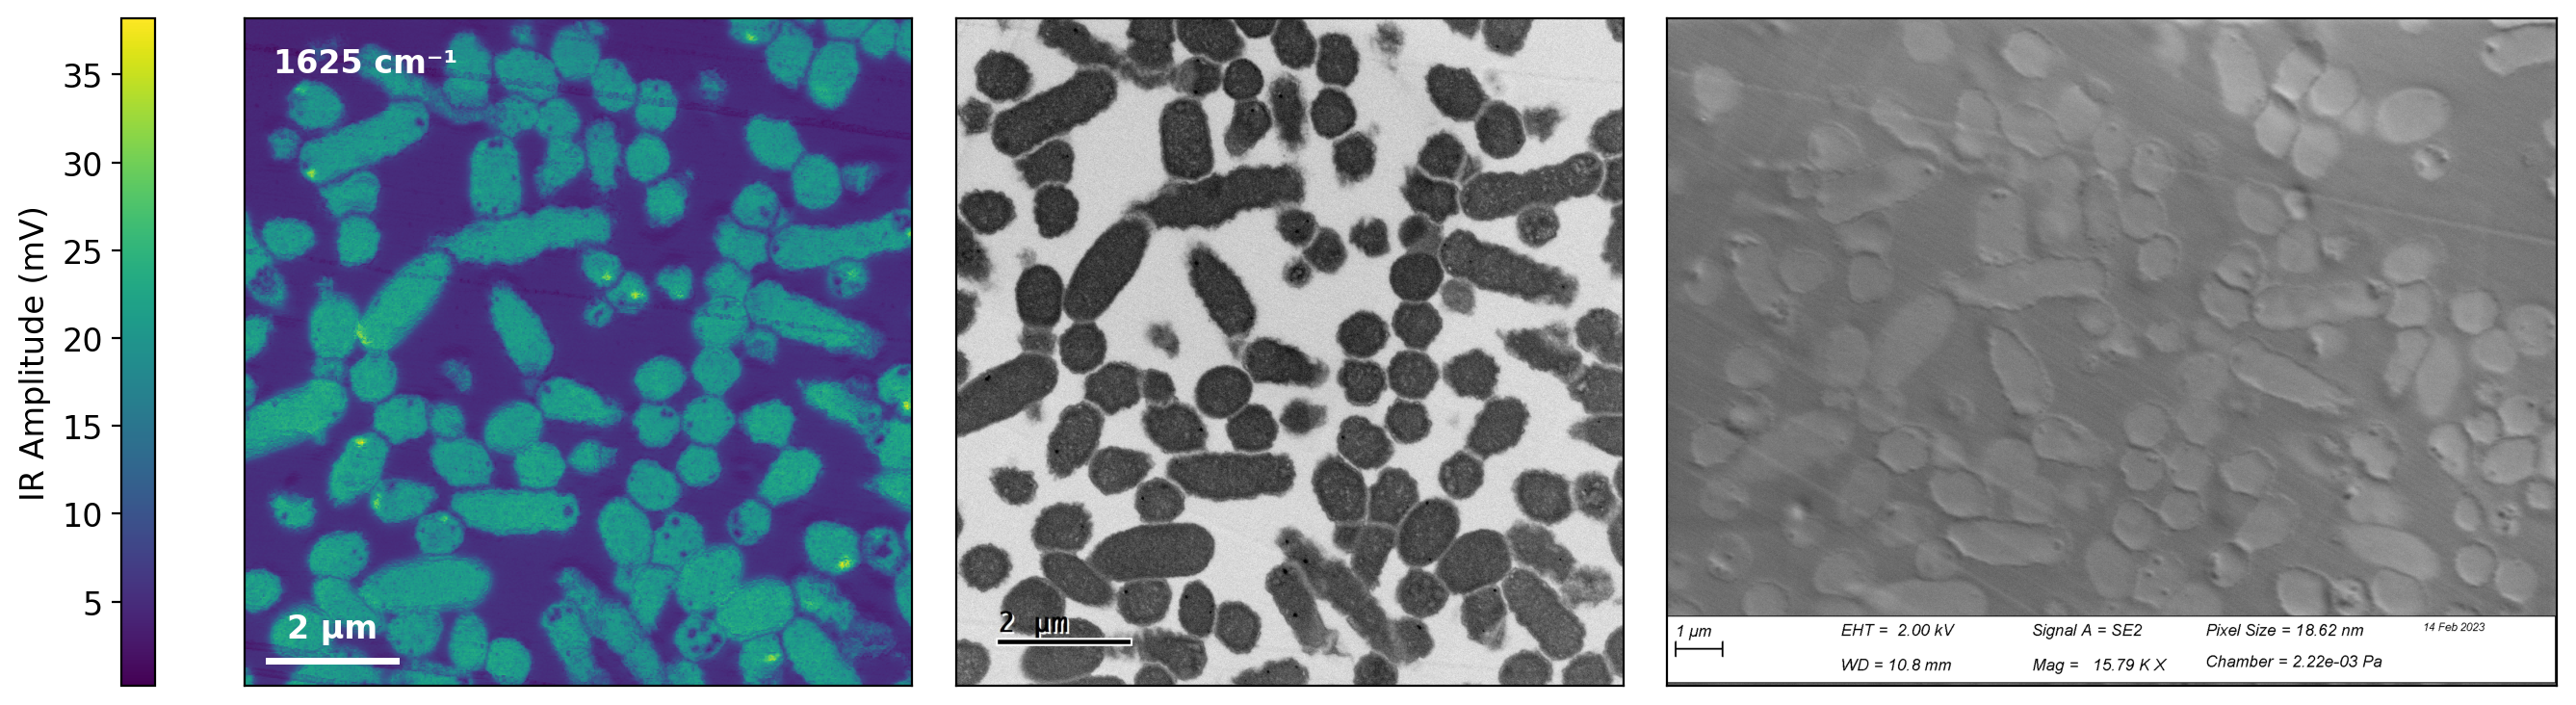

In [37]:
doc = aptwrapper.read(
    '../primary_data/supp_sem_microscopy/'
    '2023-02-08 keio wt new samples for sem/doc3_sampleA_IR.axz')
im_bse = PIL.Image.open(
    '../primary_data/supp_sem_microscopy/20230214 BS SEM AFM bacteria/'
    'Keio WT-3VBSED-2kV-21.8804kX-0005.jpg')
im_se = PIL.Image.open(
    '../primary_data/supp_sem_microscopy/20230214 SE SEM AFM bacteria/'
    'Keio WT-006.tif')

with plt.rc_context({
    'figure.figsize': (17,4.5),
    'figure.dpi': 300,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, .75, 1], 'wspace':.05})
    aptwrapper.plot_map(doc.HeightMaps['IR Amplitude 3'], ax=ax[0])
    ax[1].imshow(im_bse)
    ax[2].imshow(im_se)

    ax[1].set(xticks=[], yticks=[])
    ax[2].set(xticks=[], yticks=[])
    fig.savefig('../figures/supp_sem_microscopy.pdf')

# Purified IBs

## Load data and metadata

In [38]:
doc_h1  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230915_h1.axz')
doc_r1  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230918_r1.axz')
doc_b1  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230919_b1.axz')

doc_b4  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_b4.axz')
doc_h4a = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_h4_sessionA.axz')
doc_h4b = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_h4_sessionB.axz')
doc_r4  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_r4.axz')

doc_b7  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_b7.axz')
doc_h7  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_h7.axz')
doc_r7  = aptwrapper.read('../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_r7.axz')

In [39]:
spectra_metadata = [
    {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230919_b1.axz',
        'condition': 'B',
        'replicate': 1,
        'spectra_ib': [1, 3, #5 very small obj, 
                       7, 9, #11 not very good spectrum
                       13],
        'spectra_au': [#2 very different from the others, 
                       4, 6, 8, 10, 12, 14],
        'map_i_overview': 3,
        'map_i_detail': [4,6,7,9],
    }, {
        # Spec 19 gave very low signal which sometimes messes with normalisation
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230915_h1.axz',
        'condition': 'H',
        'replicate': 1,
        'spectra_ib': [3, 5, 7, 9, 11, 13, 15, 17, 21],
        'spectra_au': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
        'map_i_overview': [3, 5],
        'map_i_detail': [],
    }, {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/230230918_r1.axz',
        'condition': 'R',
        'replicate': 1,
        'spectra_ib': [1, 3, 5, 9, 11, 13, 
                       15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,32,33,34],
        'spectra_au': [2, 4, 6, 10, 12, 14, 16],
        'map_i_overview': 3,
        'map_i_detail': [4,5,6,7,8,9,10],
    },
    # Disregarding B4 because there are no decent au spectra
    # Disregarding H4A because the software kind of crashed
    {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_h4_sessionB.axz',
        'condition': 'H',
        'replicate': 4,
        'spectra_ib': [2, 3, 5],
        'spectra_au': [1, 4], # deleting spec6
        'map_i_overview': 1,
        'map_i_detail': [2,3],
    }, {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231004_r4.axz',
        'condition': 'R',
        'replicate': 4,
        'spectra_ib': [1, 3, 5, 7, 9],
        'spectra_au': [2, 4, 6, 8, 10],
        'map_i_overview': 2,
        'map_i_detail': [3,4,5,6,7,8],
    }, {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_b7.axz',
        'condition': 'B',
        'replicate': 7,
        'spectra_ib': [3, 5, 7, 9, 11, 13],
        'spectra_au': [4, 6, 8, 10, 12, 14],
        'map_i_overview': 2,
        'map_i_detail': [4,5,6,7,8,9,10],
    }, {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_h7.axz',
        'condition': 'H',
        'replicate': 7,
        'spectra_ib': [1, 3+1, 5+1, 7+1, 9+1, 12+1],
        'spectra_au': [2, 4+1, 6+1, 8+1, 10+1, 11+1, 13+1],
        'map_i_overview': 2,
        'map_i_detail': [3,4,5,6,7,8,9,10,11],
    }, {
        'file': '../primary_data/supp_purified_ibs/2023-09-15 AFM-IR/20231005_r7.axz',
        'condition': 'R',
        'replicate': 7,
        'spectra_ib': [1, 3, 5, 7, 9+1],
        'spectra_au': [2, 4, 6, 8+1, 10+1],
        'map_i_overview': 2,
        'map_i_detail': [3,4,5,6,7,8],
    }
]

In [40]:
def read_spectra_metadata(datasets):
    dataset_xr = []
    for dataset in datasets:
        doc = aptwrapper.read(dataset['file'])
        spec_ib = [doc.RenderedSpectra[f'Spectrum {i}'] for i in dataset['spectra_ib']]
        spec_au = [doc.RenderedSpectra[f'Spectrum {i}'] for i in dataset['spectra_au']]
        dataset_xr = dataset_xr + [
            xr.concat(spec_ib+spec_au, dim='si').assign_coords(
                condition=dataset['condition'],
                replicate=dataset['replicate'],
                sample_name=dataset['condition'] + str(dataset['replicate']),
                is_ib = ('si', [True] * len(spec_ib) + [False] * len(spec_au))
        )] 

    return xr.concat(dataset_xr, dim='si')


spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']

## Process spectra

In [41]:
def get_correction_spectra(spectra_au_raw):
    # x_au_sg = aptwrapper.savgol(x_au, 11)
    norm_factors = aptwrapper.savgol(spectra_au_raw, 30).sel(v=slice(1600,1700)).max('v')
    spec_norm = spectra_au_raw/norm_factors
    spec_au = aptwrapper.savgol(spec_norm, 5).mean('si')
    spec_peaks = (spec_norm / spec_au).mean('si')

    return spec_au, spec_peaks

def process_spectra(spec_sample):
    spec_au, spec_peaks = get_correction_spectra(spec_sample[~spec_sample.is_ib])

    # Noramlise to amide 1 peak
    norms = aptwrapper.savgol(spec_sample, 30).sel(v=slice(1600,1700)).max('v')
    spec_sample = spec_sample / norms

    # Remove water peaks
    spec_sample = spec_sample / spec_peaks
    
    # Remove Au spectrum
    norm_sample = aptwrapper.savgol(spec_sample, 30).sel(v=slice(1595,1605)).mean('v')
    norm_au = aptwrapper.savgol(spec_au, 30).sel(v=slice(1595,1605)).mean('v')
    spec_sample = spec_sample - spec_au / norm_au * norm_sample
    
    return spec_sample

def plot_spectra(x):
    fig, ax = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6,6))
    ax = ax.flatten()
    
    for i, sample_name in enumerate(['H1', 'R1', 'B1', 'H4', 'R4', '', 'H7', 'R7', 'B7']):
        s = x[x.sample_name == sample_name]
        for si in s: 
            ax[i].plot(s.v, si, c='C0', lw=.1)
        aptwrapper.annotate(ax[i], sample_name, c='k')
    ax[0].invert_xaxis()
    ax[5].axis('off')
    for a in ax[[0,3,6]]: a.set_ylabel('IR Amplitude (mV)')
    for a in ax[[6,7,8]]: a.set_xlabel('Wavenumber (cm$^{-1}$)')

spectra = read_spectra_metadata(spectra_metadata)['IR Amplitude (mV)']
spectra = spectra.groupby('sample_name').apply(process_spectra)
spectra = spectra[spectra.is_ib]
spectra = spectra/spectra.sel(v=slice(1600,1700)).max('v')

## Show maps

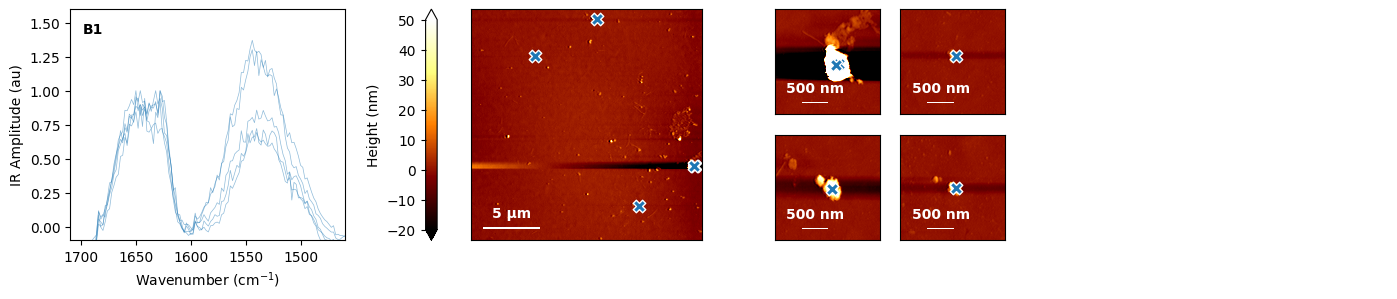

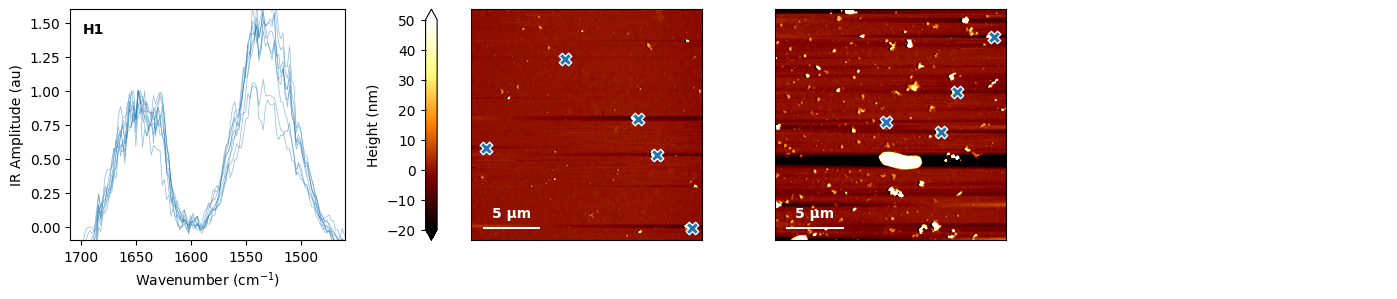

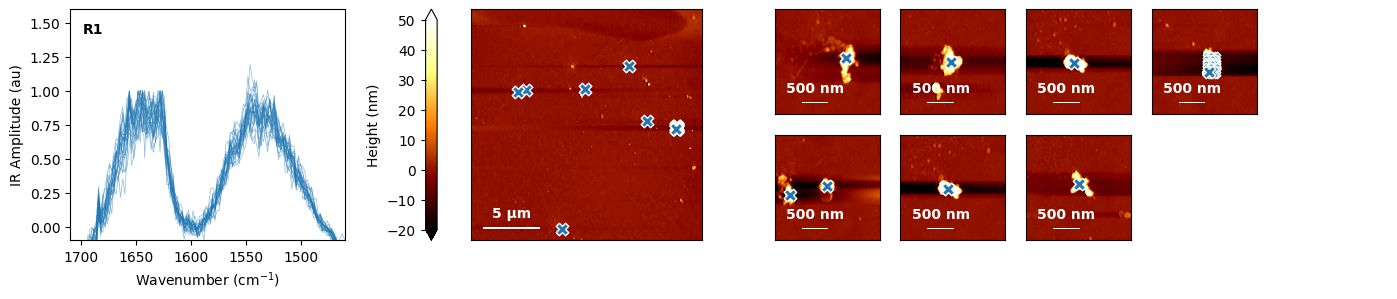

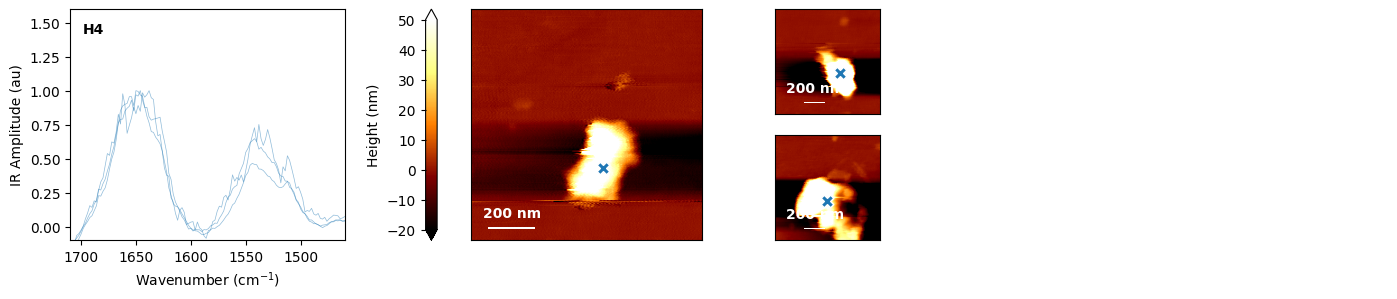

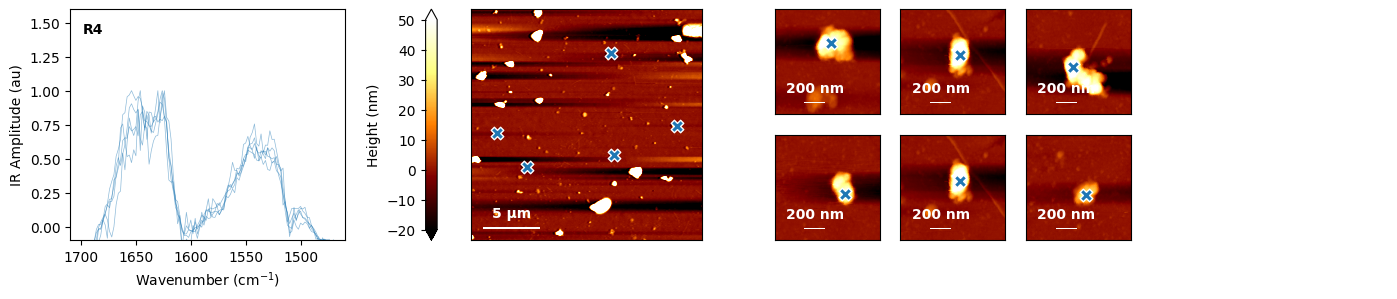

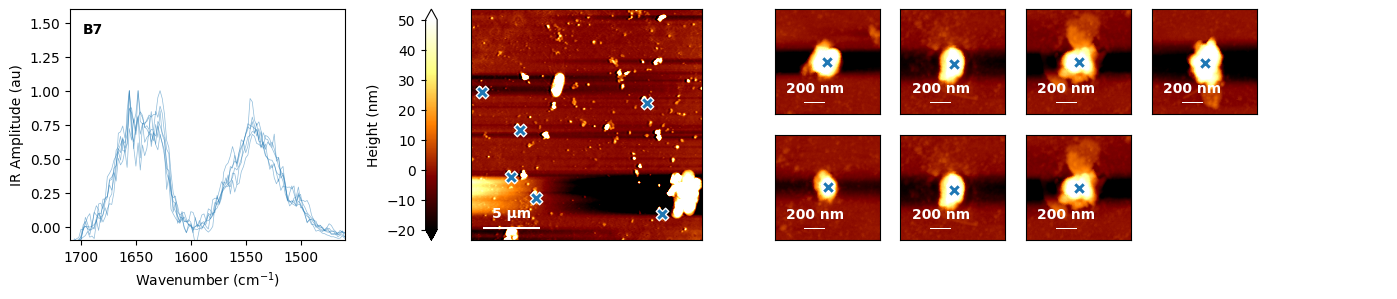

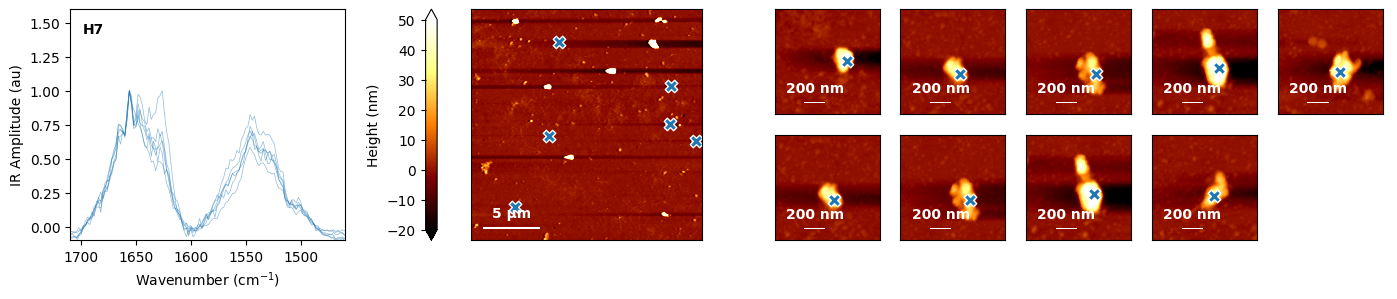

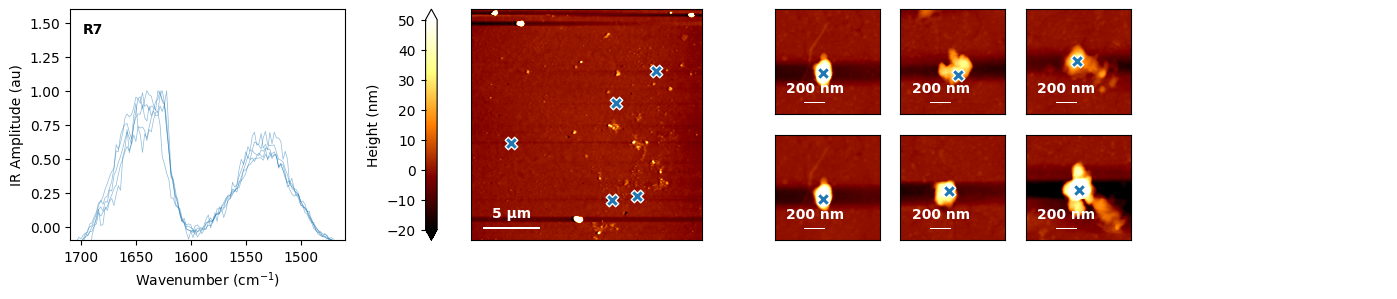

In [43]:
def show_maps(ax, doc, i_overview, i_detail, sample_name='', vmin=-20, vmax=50, spectra_i=None, extra_overview=None):
    
    # Define grids
    ax.axis('off')
    gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        1, 3, subplot_spec=ax, width_ratios = [.8, 1, 1.8], wspace=.1, hspace=.1
    )
    sgs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        2, 5, subplot_spec=gs[2], wspace=.1
    )

    map_ax = []

    # Plot main map
    def plot_map(axi, map, robust=True, **kwargs):
        aptwrapper.plot_map(map, axi, vmin=vmin, vmax=vmax, **kwargs)
        axi.set(xlim=(map.X.min(), map.X.max()), ylim=(map.Y.min(), map.Y.max()))
    
    if isinstance(i_overview, list):
        axi = ax.figure.add_subplot(gs[1])
        map_ax.append(axi)
        plot_map(axi, doc.HeightMaps[f'Height {i_overview[0]}'])

        axi = ax.figure.add_subplot(sgs[:2,:2])
        map_ax.append(axi)
        plot_map(axi, doc.HeightMaps[f'Height {i_overview[1]}'], colorbar=False)

    else: 
        axi = ax.figure.add_subplot(gs[1])
        map_ax.append(axi)
        plot_map(axi, doc.HeightMaps[f'Height {i_overview}'])

        # Plot detail maps
        for axi, mapi in enumerate(i_detail):
            axi = ax.figure.add_subplot(sgs[axi % 2, axi // 2]) 
            map_ax.append(axi)

            plot_map(
                axi,
                doc.HeightMaps[f'Height {mapi}'],
                cb_label='',
                colorbar=False
            )

    # Plot spectra locations
    # if spectra_i is not None:
    #     for i in spectra_i:
    #         s = doc.RenderedSpectra[f'Spectrum {i}']
    #         for a in map_ax:
    #             aptwrapper.mark_location(s, ax=a, color='C0')
            
    ss = spectra[spectra.sample_name == sample_name]
    sax = ax.figure.add_subplot(gs[0])
    for i, s in enumerate(ss):
        for a in map_ax:
            aptwrapper.mark_location(s, ax=a, color='C0', label=f'S{i+1}')
        sax.plot(s.v, s, c='C0', lw=.5, alpha=.5)
    sax.invert_xaxis()
    aptwrapper.annotate(sax, sample_name, c='k')
    sax.set(xlabel='Wavenumber (cm$^{-1}$)', ylabel='IR Amplitude (au)', ylim=[-.1,1.6], xlim=[1710,1460])

def show_data_from_meta(md):
    doc = aptwrapper.read(md['file'])
    fig, ax = plt.subplots(figsize=(17, 3))
    show_maps(
        ax,
        doc,
        md['map_i_overview'],
        md['map_i_detail'],
        sample_name=md['condition'] + str(md['replicate']),
        spectra_i = md['spectra_ib']
    )
    return fig

import os
output_directory = "../figures/supp_purified_ibs/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
for v in spectra_metadata:
    fig = show_data_from_meta(v)
    fig.savefig(f'../figures/supp_purified_ibs/{v["condition"]}{v["replicate"]}.pdf')

## Quantification

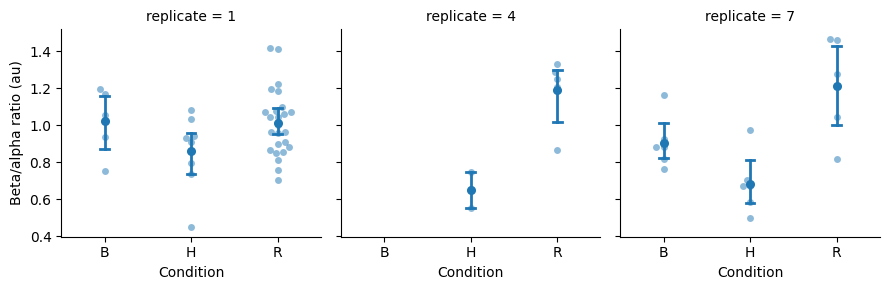

In [44]:
import xarray as xr

df = xr.Dataset({
    'beta': spectra.sel(v=slice(1615, 1635)).mean('v'),
    'alpha': spectra.sel(v=slice(1650, 1670)).mean('v'),
}).to_dataframe().assign(ratio=lambda x: x.beta/x.alpha)

grid = sns.FacetGrid(
    df, col='replicate', sharey=True
)
grid.map_dataframe(sns.swarmplot, x='condition', y='ratio', alpha=.5)
grid.map_dataframe(
    sns.pointplot, x='condition', y='ratio', 
    errorbar=('ci', 95), ls='', marker='o', capsize=.1, lw=2, color='C0'  
)
grid.set_xlabels('Condition')
grid.set_ylabels('Beta/alpha ratio (au)')

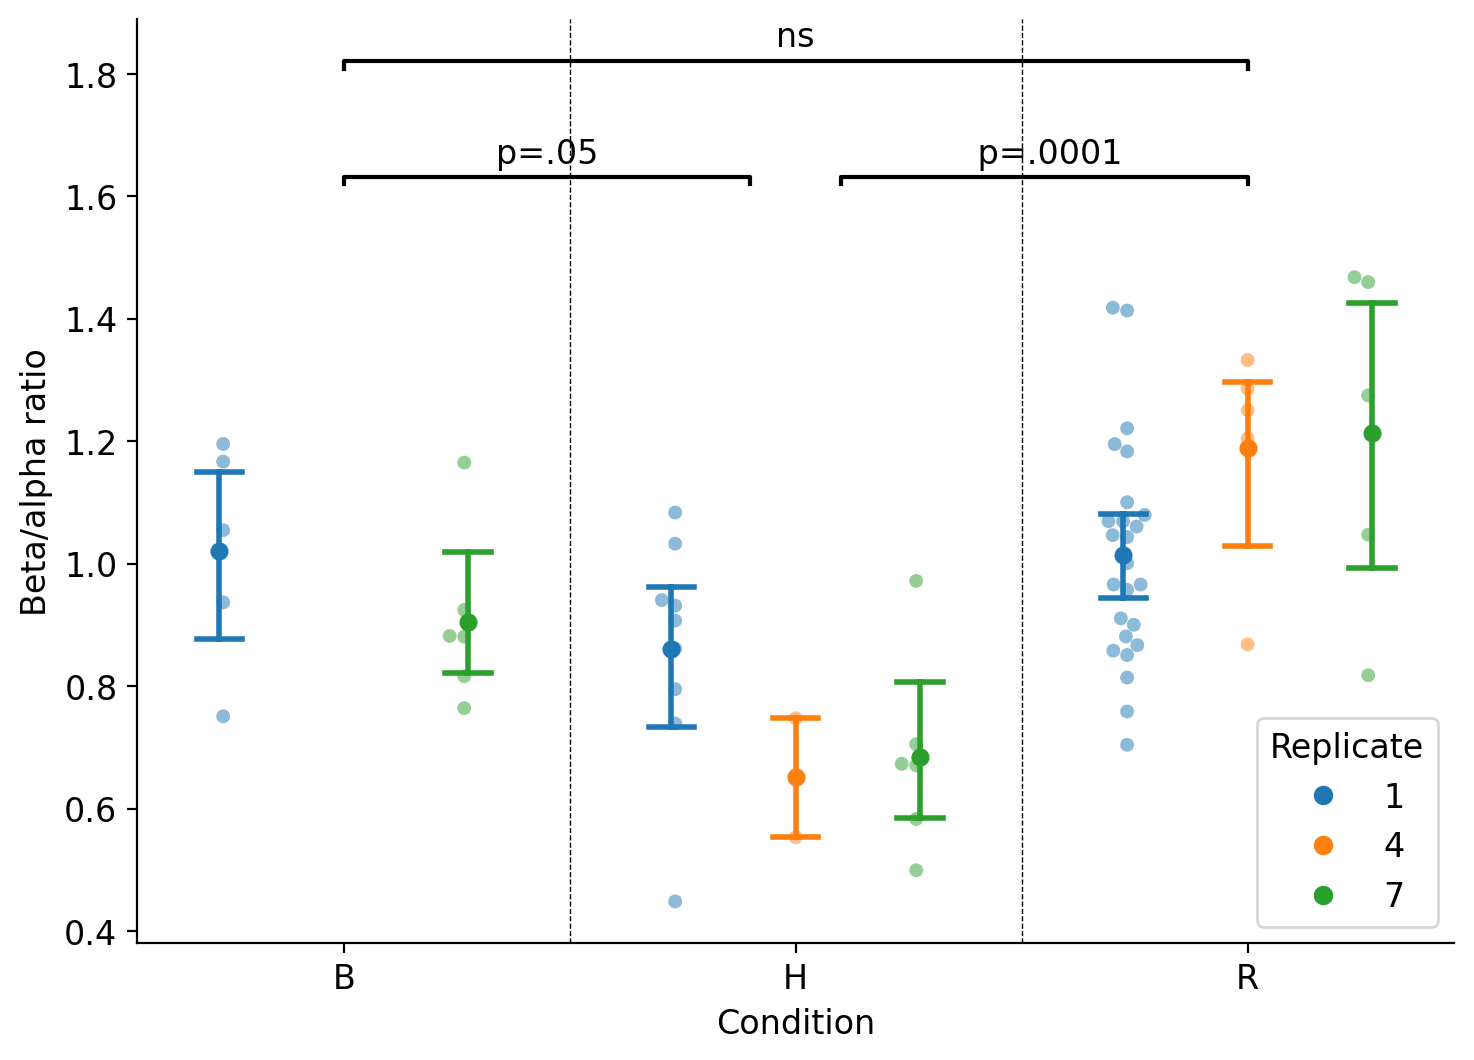

In [84]:
from matplotlib.lines import Line2D

with plt.rc_context({
    'figure.figsize': (17/2,6),
    'figure.dpi': 300,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    fig, ax = plt.subplots()

    sns.swarmplot(
        data=df, x='condition', y='ratio', 
        hue='replicate', palette='tab10', dodge=1,
        alpha=.5
    )

    sns.pointplot(
        data=df, x='condition', y='ratio', 
        hue='replicate', palette='tab10', dodge=.55,
        errorbar=('ci', 95), ls='', marker='o', capsize=.1, lw=2, legend=False
    )

    plt.axvline(0.5, c='k', ls='--', lw=.5)
    plt.axvline(1.5, c='k', ls='--', lw=.5)
    plt.ylabel('Beta/alpha ratio')
    plt.xlabel('Condition')
    sns.despine()
    plt.legend(title='Replicate', handles=[
        Line2D([0], [0], marker='o', lw=0, c='C0', label=1),
        Line2D([0], [0], marker='o', lw=0, c='C1', label=4),
        Line2D([0], [0], marker='o', lw=0, c='C2', label=7),
    ], loc='lower right')
    utils.annot(ax, [.45, 1.55], .45, ['p=.05',' p=.0001'])
    utils.annot(ax, 1, 1, 'ns')

    fig.savefig('../figures/supp_purified_ibs/quantification.pdf')

In [47]:
import utils

In [52]:
utils.test_mean_differences(
    df.query('condition != "B"'),
    outcome='ratio',
    groupby='condition',
    mean_over='replicate',
)

reject_H0                          True
using_anova                        True
p_anova                        0.043125
p_kruskal                      0.198138
p_shapiro                [1.098, 0.888]
p_bartlett                      3.88823
n_per_group                      [3, 3]
bonferroni_multiplier                 4
dtype: object

In [ ]:
dff = (
    df
    .groupby(['replicate', 'condition'])
    .mean(numeric_only=True)
    .reset_index()
)

pd.DataFrame([
    scipy.stats.mannwhitneyu(df[df.condition == c[0]].ratio, df[df.condition == c[1]].ratio)._asdict()
    for c in ['BH', 'BR', 'HR']
], index=['BH', 'BR', 'HR']).assign(p_adj = lambda x: x.pvalue * 3)

statistic    pvalue     p_adj
BH      153.0  0.016188  0.048564
BR      134.0  0.135276  0.405827
HR       94.0  0.000035  0.000104